In [1]:
import re
import numpy as np
import pandas as pd
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from nltk.util import ngrams
from tqdm import tqdm
import time

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
permulaan = [
    'bel',
    'se',
    'ter',
    'men',
    'meng',
    'mem',
    'memper',
    'di',
    'pe',
    'me',
    'ke',
    'ber',
    'pen',
    'per',
]

hujung = ['kan', 'kah', 'lah', 'tah', 'nya', 'an', 'wan', 'wati', 'ita']

def naive_stemmer(word):
    assert isinstance(word, str), 'input must be a string'
    hujung_result = re.findall(r'^(.*?)(%s)$' % ('|'.join(hujung)), word)
    word = hujung_result[0][0] if len(hujung_result) else word
    permulaan_result = re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan[::-1])), word)
    permulaan_result.extend(re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan)), word))
    mula = permulaan_result if len(permulaan_result) else ''
    if len(mula):
        mula = mula[1][1] if len(mula[1][1]) > len(mula[0][1]) else mula[0][1]
    return word.replace(mula, '')

def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def classification_textcleaning(string):
    string = re.sub(
        'http\S+|www.\S+',
        '',
        ' '.join(
            [i for i in string.split() if i.find('#') < 0 and i.find('@') < 0]
        ),
    )
    string = unidecode(string).replace('.', ' . ').replace(',', ' , ')
    string = re.sub('[^A-Za-z ]+', ' ', string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = ' '.join(
        [i for i in re.findall('[\\w\']+|[;:\-\(\)&.,!?"]', string) if len(i)]
    )
    string = string.lower().split()
    string = [(naive_stemmer(word), word) for word in string]
    return (
        ' '.join([word[0] for word in string if len(word[0]) > 1]),
        ' '.join([word[1] for word in string if len(word[0]) > 1]),
    )


def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            val = dic[k] if k in dic else UNK
            X[i, -1 - no] = val
    return X

In [4]:
df = pd.read_csv('toxic-bm.csv')
df = df.dropna()
df.shape

(40911, 7)

In [7]:
for i in range(df.shape[0]):
    df.iloc[i,0] = classification_textcleaning(df.iloc[i,0])[0]

In [8]:
texts = df.iloc[:,0].tolist()
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 55906
Most common words [('yang', 103249), ('anda', 68711), ('tidak', 54325), ('untuk', 50517), ('ada', 39335), ('saya', 32581)]
Sample data [68, 96, 78, 4, 41, 126, 276, 2599, 6314, 73] ['jelas', 'gapa', 'gedit', 'yang', 'buat', 'bawah', 'minat', 'tegar', 'tallica', 'nama']


In [11]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y = df[list_classes].values
Y.shape

(40911, 6)

In [9]:
class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        W = tf.get_variable(
            'w',
            shape = (size_layer, dimension_output),
            initializer = tf.glorot_uniform_initializer(),
        )
        b = tf.get_variable(
            'b',
            shape = (dimension_output),
            initializer = tf.zeros_initializer(),
        )
        self.logits = tf.add(tf.matmul(outputs[:, -1], W), b, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(self.logits)), tf.round(self.Y))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [13]:
size_layer = 256
num_layers = 2
dimension_output = Y.shape[1]
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 80

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [14]:
vectors = str_idx(df.iloc[:,0].tolist(), dictionary, maxlen)
train_X, test_X, train_Y, test_Y = train_test_split(
    vectors, Y, test_size = 0.2
)

In [15]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = train_X[i : min(i + batch_size, train_X.shape[0])]
        batch_y = train_Y[i : min(i + batch_size, train_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
        batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1

    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1


train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

epoch: 0, pass acc: 0.000000, current acc: 0.973983
time taken: 1172.8256270885468
epoch: 0, training loss: 0.130629, training acc: 0.963412, valid loss: 0.089508, valid acc: 0.973983



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

epoch: 1, pass acc: 0.973983, current acc: 0.976081
time taken: 293.0026590824127
epoch: 1, training loss: 0.082537, training acc: 0.974315, valid loss: 0.078792, valid acc: 0.976081



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

epoch: 2, pass acc: 0.976081, current acc: 0.976964
time taken: 251.9325828552246
epoch: 2, training loss: 0.071557, training acc: 0.976610, valid loss: 0.075631, valid acc: 0.976964



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

time taken: 250.3645830154419
epoch: 3, training loss: 0.065284, training acc: 0.977995, valid loss: 0.074502, valid acc: 0.976781



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

epoch: 4, pass acc: 0.976964, current acc: 0.977107
time taken: 250.42156171798706
epoch: 4, training loss: 0.059939, training acc: 0.979338, valid loss: 0.073523, valid acc: 0.977107



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

epoch: 5, pass acc: 0.977107, current acc: 0.977290
time taken: 259.5673520565033
epoch: 5, training loss: 0.055244, training acc: 0.980611, valid loss: 0.075217, valid acc: 0.977290



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

time taken: 270.63135743141174
epoch: 6, training loss: 0.050431, training acc: 0.982159, valid loss: 0.077296, valid acc: 0.977026



train minibatch loop:   0%|          | 0/1023 [00:00<?, ?it/s]

time taken: 254.7599949836731
epoch: 7, training loss: 0.046363, training acc: 0.983582, valid loss: 0.080549, valid acc: 0.976883



test minibatch loop: 100%|██████████| 256/256 [00:18<00:00, 14.18it/s, accuracy=1, cost=0.0139]    

time taken: 249.45675706863403
epoch: 8, training loss: 0.042123, training acc: 0.985135, valid loss: 0.086130, valid acc: 0.976272

break epoch:9



In [16]:
stack = []
pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
for i in pbar:
    batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
    batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
    stack.append(sess.run(tf.nn.sigmoid(model.logits),
                         feed_dict = {model.X: batch_x}))

test minibatch loop: 100%|██████████| 256/256 [00:37<00:00,  6.37it/s]


In [17]:
print(metrics.classification_report(test_Y,np.around(np.concatenate(stack,axis=0))))

             precision    recall  f1-score   support

          0       0.75      0.58      0.65       797
          1       0.46      0.36      0.41        77
          2       0.71      0.59      0.64       423
          3       0.00      0.00      0.00        30
          4       0.68      0.56      0.61       384
          5       0.40      0.23      0.29        74

avg / total       0.69      0.54      0.60      1785



In [25]:
text = 'bodoh lah anti sosial'
new_vector = str_idx([classification_textcleaning(text)[0]], dictionary, maxlen)
sess.run(tf.nn.sigmoid(model.logits), feed_dict={model.X:new_vector})

array([[0.9814238 , 0.07019142, 0.78172404, 0.02179804, 0.9483101 ,
        0.30378604]], dtype=float32)

In [26]:
import json
with open('bahdanau-toxic.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [27]:
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [28]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [30]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

freeze_graph('bahdanau', strings)

INFO:tensorflow:Restoring parameters from bahdanau/model.ckpt
INFO:tensorflow:Froze 11 variables.
INFO:tensorflow:Converted 11 variables to const ops.
458 ops in the final graph.


In [31]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [32]:
g = load_graph('bahdanau/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
test_sess.run([logits, alphas], feed_dict = {x: new_vector})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[array([[ 3.9710352, -2.6655428,  1.439822 , -4.383592 ,  2.9508197,
         -1.1368153]], dtype=float32),
 array([3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        3.1028743e-17, 3.1028743e-17, 3.1028743e-17, 3.1028743e-17,
        

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [34]:
text = classification_textcleaning(text)
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
result = test_sess.run([tf.nn.softmax(logits), alphas], feed_dict = {x: new_vector})

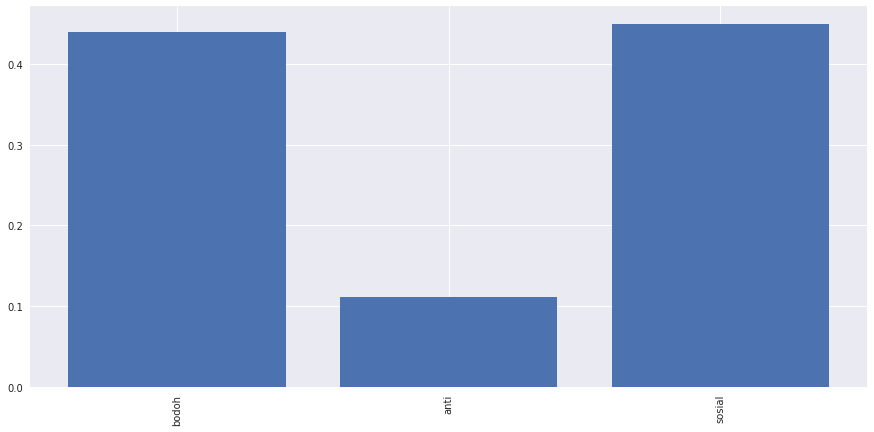

In [35]:
plt.figure(figsize = (15, 7))
labels = [word for word in text[1].split()]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.show()